In [1]:
"""
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from itertools import product
import gc
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
"""

'\n# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python\n# For example, here\'s several helpful packages to load\n\nimport numpy as np # linear algebra\nimport pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\nfrom sklearn.preprocessing import LabelEncoder\nfrom itertools import product\nimport gc\nimport re\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/kaggle/input\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" \n# You can also write temporary files to /kaggle/temp/, b

In [2]:
# https://www.kaggle.com/yiyangevandai/predict-future-sales
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from itertools import product
import gc    #ガベージコレクション用のモジュール(メモリを動的に確保すること)
import re
import os
from xgboost import XGBRegressor, plot_importance   #xgboost: treeの勾配ブースティングによる高性能な分類・予測モデル。kaggleで大人気(詳しい説明は下へ)
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = 'C:\\Users\\shota\\OneDrive\\ドキュメント\\Data\\Kaggle\\kc_Predict_Future_Sales\\'
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\shota\OneDrive\ドキュメント\Data\Kaggle\kc_Predict_Future_Sales\items.csv
C:\Users\shota\OneDrive\ドキュメント\Data\Kaggle\kc_Predict_Future_Sales\item_categories.csv
C:\Users\shota\OneDrive\ドキュメント\Data\Kaggle\kc_Predict_Future_Sales\sales_train.csv
C:\Users\shota\OneDrive\ドキュメント\Data\Kaggle\kc_Predict_Future_Sales\sample_submission.csv
C:\Users\shota\OneDrive\ドキュメント\Data\Kaggle\kc_Predict_Future_Sales\shops.csv
C:\Users\shota\OneDrive\ドキュメント\Data\Kaggle\kc_Predict_Future_Sales\test.csv


In [4]:
"""
items_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_categories_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
sales_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
shops_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
"""

"\nitems_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')\nitem_categories_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')\nsales_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')\nshops_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')\ntest_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')\n"

In [5]:
#Load Data
items_df = pd.read_csv(DATA_PATH + 'items.csv')
item_categories_df = pd.read_csv(DATA_PATH + 'item_categories.csv')
sales_df = pd.read_csv(DATA_PATH + 'sales_train.csv')
shops_df = pd.read_csv(DATA_PATH + 'shops.csv')
test_df = pd.read_csv(DATA_PATH + 'test.csv')

In [6]:
"""
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df
"""

'\ndef downcast_dtypes(df):\n    \'\'\'\n        Changes column types in the dataframe: \n                \n                `float64` type to `float32`\n                `int64`   type to `int32`\n    \'\'\'\n    \n    # Select columns to downcast\n    float_cols = [c for c in df if df[c].dtype == "float64"]\n    int_cols =   [c for c in df if df[c].dtype == "int64"]\n    \n    # Downcast\n    df[float_cols] = df[float_cols].astype(np.float32)\n    df[int_cols]   = df[int_cols].astype(np.int32)\n    \n    return df\n'

In [7]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype == 'int64']
    
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int32)
    
    return df

In [8]:
"""
# get the type of the items and label them
item_categories_df['type'] = item_categories_df['item_category_name'].str.split('-').map(lambda x:x[0])
item_categories_df['type_code'] = LabelEncoder().fit_transform(item_categories_df['type'])

# get the sub type of the items and label them
item_categories_df['sub_type'] = item_categories_df['item_category_name'].str.split('-').map(lambda x:x[1].strip() 
                                                                                             if len(x) > 1 else x[0].strip())
item_categories_df['sub_type_code'] = LabelEncoder().fit_transform(item_categories_df['sub_type'])
item_categories_df.head()

"""

"\n# get the type of the items and label them\nitem_categories_df['type'] = item_categories_df['item_category_name'].str.split('-').map(lambda x:x[0])\nitem_categories_df['type_code'] = LabelEncoder().fit_transform(item_categories_df['type'])\n\n# get the sub type of the items and label them\nitem_categories_df['sub_type'] = item_categories_df['item_category_name'].str.split('-').map(lambda x:x[1].strip() \n                                                                                             if len(x) > 1 else x[0].strip())\nitem_categories_df['sub_type_code'] = LabelEncoder().fit_transform(item_categories_df['sub_type'])\nitem_categories_df.head()\n\n"

In [9]:
# Preprcoess item_categories_df

In [10]:
item_categories_df['type'] = item_categories_df['item_category_name'].str.split('-').map(lambda x: x[0])
item_categories_df['type_code'] = LabelEncoder().fit_transform(item_categories_df['type'])   
# LabelEncoder()の例: ['positive', 'negative', 'positive'] は [0, 1, 0] が出力される (#リストの各要素は文字列でも良いですし，数値でも良いです)

item_categories_df['sub_type'] = item_categories_df['item_category_name'].str.split('-').map(lambda x:x[1].strip()
                                                                                              if len(x) > 1 else x[0].strip())
item_categories_df['sub_type_code'] = LabelEncoder().fit_transform(item_categories_df['sub_type'])
"""
fit_transform()
fit()とtransform()を一気に行う場合，fit_transform()を使うと楽です．

入力がラベルの一次元リスト，出力がラベルIDの一次元リストになっています
"""
item_categories_df.head()

,item_category_name,item_category_id,type,type_code,sub_type,sub_type_code
0,PC - Гарнитуры/Наушники,0,PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,Аксессуары,1,PSP,13


In [11]:
"""
shops_df.loc[shops_df['shop_name']=='Сергиев Посад ТЦ "7Я"','shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x:x[0])
shops_df.loc[shops_df['city'] == '!Якутск','city']='Якутск'
shops_df['city_code'] = LabelEncoder().fit_transform(shops_df['city'])
shops_df.head()
"""

'\nshops_df.loc[shops_df[\'shop_name\']==\'Сергиев Посад ТЦ "7Я"\',\'shop_name\'] = \'СергиевПосад ТЦ "7Я"\'\nshops_df[\'city\'] = shops_df[\'shop_name\'].str.split(\' \').map(lambda x:x[0])\nshops_df.loc[shops_df[\'city\'] == \'!Якутск\',\'city\']=\'Якутск\'\nshops_df[\'city_code\'] = LabelEncoder().fit_transform(shops_df[\'city\'])\nshops_df.head()\n'

In [12]:
#Preprcoess shops_df

In [13]:
shops_df.loc[shops_df['shop_name']=='Сергиев Посад ТЦ "7Я"','shop_name'] = 'СергиевПосад ТЦ "7Я"'    #split時に困るため、書き直した
shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x:x[0])
shops_df.loc[shops_df['city'] == '!Якутск','city']='Якутск'
shops_df['city_code'] = LabelEncoder().fit_transform(shops_df['city'])
shops_df.head()

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [14]:
"""
# replace the negative item_price to mean value
mean = sales_df[(sales_df["shop_id"] == 32) & (sales_df["item_id"] == 2973) & 
                (sales_df["date_block_num"] == 4) & (sales_df["item_price"] > 0)]["item_price"].mean()
sales_df.loc[sales_df.item_price < 0, 'item_price'] = mean

# clean the outliers
sales_df = sales_df[sales_df["item_price"] < np.percentile(sales_df["item_price"], q = 100)]
sales_df = sales_df[(sales_df["item_cnt_day"] >= 0) & (sales_df["item_cnt_day"] < np.percentile(sales_df["item_cnt_day"], q = 100))]

# change the format of date
sales_df["date"] = pd.to_datetime(sales_df["date"], format = "%d.%m.%Y")
sales_df.head()
"""

'\n# replace the negative item_price to mean value\nmean = sales_df[(sales_df["shop_id"] == 32) & (sales_df["item_id"] == 2973) & \n                (sales_df["date_block_num"] == 4) & (sales_df["item_price"] > 0)]["item_price"].mean()\nsales_df.loc[sales_df.item_price < 0, \'item_price\'] = mean\n\n# clean the outliers\nsales_df = sales_df[sales_df["item_price"] < np.percentile(sales_df["item_price"], q = 100)]\nsales_df = sales_df[(sales_df["item_cnt_day"] >= 0) & (sales_df["item_cnt_day"] < np.percentile(sales_df["item_cnt_day"], q = 100))]\n\n# change the format of date\nsales_df["date"] = pd.to_datetime(sales_df["date"], format = "%d.%m.%Y")\nsales_df.head()\n'

In [15]:
#Preprcoess sales_df

In [16]:
sales_df[(sales_df["shop_id"] == 32) & (sales_df['item_id'] == 2973) &
                (sales_df['date_block_num'] == 4) & (sales_df['item_price'] > 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


In [17]:
mean = sales_df[(sales_df["shop_id"] == 32) & (sales_df['item_id'] == 2973) &
                (sales_df['date_block_num'] == 4) & (sales_df['item_price'] > 0)]['item_price'].mean()  #値段が変わっているので、その中央値を当てはめる
sales_df.loc[sales_df.item_price < 0, 'item_price'] = mean

sales_df = sales_df[sales_df['item_price'] < np.percentile(sales_df['item_price'], q=100)]   #幾つかの数値データを小さい順に並べたとき、小さい方から数えて全体のX%に位置する値をXパーセンタイルと言います。
sales_df = sales_df[(sales_df['item_cnt_day'] >= 0) & (sales_df['item_cnt_day'] < np.percentile(sales_df['item_cnt_day'], q=100))]

sales_df['date'] = pd.to_datetime(sales_df['date'], format='%d.%m.%Y')
sales_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [18]:
"""
for i in [(0, 57), (1, 58), (10, 11)]:
    sales_df.loc[sales_df['shop_id'] == i[0], 'shop_id'] = i[1]
    test_df.loc[test_df['shop_id'] == i[0], 'shop_id'] = i[1]
"""

"\nfor i in [(0, 57), (1, 58), (10, 11)]:\n    sales_df.loc[sales_df['shop_id'] == i[0], 'shop_id'] = i[1]\n    test_df.loc[test_df['shop_id'] == i[0], 'shop_id'] = i[1]\n"

In [19]:
for i in [(0,57), (1, 58), (10, 11)]:
    print(i)

(0, 57)
(1, 58)
(10, 11)


In [20]:
for i in [(0,57), (1, 58), (10, 11)]:
    sales_df.loc[sales_df['shop_id'] == i[0], 'shop_id'] = i[1]
    test_df.loc[test_df['shop_id'] == i[0], 'shop_id'] = i[1]

In [21]:
"""
sales_df['revenue'] = sales_df['item_cnt_day'] * sales_df['item_price']
"""

"\nsales_df['revenue'] = sales_df['item_cnt_day'] * sales_df['item_price']\n"

In [22]:
sales_df['revenue'] = sales_df['item_cnt_day'] * sales_df['item_price']

In [23]:
"""
def name_correction(x):
    x = x.lower() #lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

"""

"\ndef name_correction(x):\n    x = x.lower() #lower case\n    x = x.partition('[')[0] # partition by square brackets\n    x = x.partition('(')[0] # partition by curly brackets\n    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters\n    x = x.replace('  ', ' ') # replace double spaces with single spaces\n    x = x.strip() # remove leading and trailing white space\n    return x\n\n"

In [24]:
# Preprcoess items_df

In [25]:
def name_correction(x):
    x = x.lower()    #小文字に変換
    x = x.partition('[')[0]   
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9A-Яа-я]+', ' ', x)   #re.sub()では第一引数に正規表現パターン、第二引数に置換先文字列、第三引数に処理対象の文字列を指定する。
    x = x.replace('  ', ' ')
    x = x.strip()  # 空白を除去
    return x

In [26]:
"""
# split item names by first bracket
items_df['name1'], items_df['name2'] = items_df['item_name'].str.split('[', 1).str
items_df['name1'], items_df['name3'] = items_df['item_name'].str.split('(', 1).str

# replace special characters and turn to lower case
items_df['name2'] = items_df['name2'].str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items_df['name3'] = items_df['name3'].str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items_df = items_df.fillna('0')

items_df['item_name'] = items_df['item_name'].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - the closing bracket
items_df['name2'] = items_df['name2'].apply(lambda x: x[:-1] if x != '0' else '0')
"""

'\n# split item names by first bracket\nitems_df[\'name1\'], items_df[\'name2\'] = items_df[\'item_name\'].str.split(\'[\', 1).str\nitems_df[\'name1\'], items_df[\'name3\'] = items_df[\'item_name\'].str.split(\'(\', 1).str\n\n# replace special characters and turn to lower case\nitems_df[\'name2\'] = items_df[\'name2\'].str.replace(\'[^A-Za-z0-9А-Яа-я]+\', " ").str.lower()\nitems_df[\'name3\'] = items_df[\'name3\'].str.replace(\'[^A-Za-z0-9А-Яа-я]+\', " ").str.lower()\n\n# fill nulls with \'0\'\nitems_df = items_df.fillna(\'0\')\n\nitems_df[\'item_name\'] = items_df[\'item_name\'].apply(lambda x: name_correction(x))\n\n# return all characters except the last if name 2 is not "0" - the closing bracket\nitems_df[\'name2\'] = items_df[\'name2\'].apply(lambda x: x[:-1] if x != \'0\' else \'0\')\n'

In [27]:
items_df['name1'], items_df['name2'] = items_df['item_name'].str.split('[', 1).str
items_df['name1'], items_df['name3'] = items_df['item_name'].str.split('(', 1).str

items_df['name2'] = items_df['name2'].str.replace('[^A-Za-z0-9A-Яа-я]+', " ").str.lower()
items_df['name3'] = items_df['name3'].str.replace('[^A-Za-z0-9A-Яа-я]+', " ").str.lower()

items_df = items_df.fillna('0')   # fill nulls with '0'

items_df['item_name'] = items_df['item_name'].apply(lambda x: name_correction(x))

items_df['name2'] = items_df['name2'].apply(lambda x: x[:-1] if x != '0' else '0')

<ipython-input-27-a8466b510f5b>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items_df['name1'], items_df['name2'] = items_df['item_name'].str.split('[', 1).str
<ipython-input-27-a8466b510f5b>:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  items_df['name1'], items_df['name3'] = items_df['item_name'].str.split('(', 1).str
<ipython-input-27-a8466b510f5b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  items_df['name2'] = items_df['name2'].str.replace('[^A-Za-z0-9A-Яа-я]+', " ").str.lower()
<ipython-input-27-a8466b510f5b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  items_df['name3'] = items_df['name3'].str.replace('[^A-Za-z0-9A-Яа-я]+', " ").str.lower()


In [28]:
items_df.head()

,item_name,item_id,item_category_id,name1,name2,name3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,коробка,4,40,***КОРОБКА,0,стекло d


In [29]:
"""
items_df['type'] = (items_df['name2'].apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0]))

items_df.loc[(items_df['type'] == 'x360')|(items_df['type'] == 'xbox360')|(items_df['type'] == 'xbox 360'),'type'] = 'xbox 360'
items_df.loc[items_df['type'] == '', 'type'] = 'mac'
items_df.type = (items_df['type'].apply(lambda x: x.replace(' ', '')))
items_df.loc[(items_df['type'] == 'pc' )|(items_df['type'] == 'pс')|(items_df['type'] == 'pс'),'type'] = 'pс'

items_df.loc[items_df['type'] == 'рs3' , 'type'] = 'рs3'
"""

"\nitems_df['type'] = (items_df['name2'].apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0]))\n\nitems_df.loc[(items_df['type'] == 'x360')|(items_df['type'] == 'xbox360')|(items_df['type'] == 'xbox 360'),'type'] = 'xbox 360'\nitems_df.loc[items_df['type'] == '', 'type'] = 'mac'\nitems_df.type = (items_df['type'].apply(lambda x: x.replace(' ', '')))\nitems_df.loc[(items_df['type'] == 'pc' )|(items_df['type'] == 'pс')|(items_df['type'] == 'pс'),'type'] = 'pс'\n\nitems_df.loc[items_df['type'] == 'рs3' , 'type'] = 'рs3'\n"

In [30]:
items_df['type'] = (items_df['name2'].apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0]))

items_df.loc[(items_df['type'] == 'x360')|(items_df['type'] == 'xbox360')|(items_df['type'] == 'xbox 360'), 'type'] = 'xbox 360'
items_df.loc[items_df['type'] == '', 'type'] = 'mac'
items_df.type = (items_df['type'].apply(lambda x: x.replace(' ', '')))
items_df.loc[(items_df['type'] == 'pc')|(items_df['type'] == 'pc')|(items_df['type'] == 'pc'), 'type'] = 'pc'

items_df.loc[items_df['type'] == 'ps3', 'type'] = 'ps3'

In [31]:
items_df['type']

0               0
1              pc
2               0
3               0
4               0
           ...   
22165          pc
22166    цифровая
22167           0
22168           0
22169           0
Name: type, Length: 22170, dtype: object

In [32]:
items_df.type

0               0
1              pc
2               0
3               0
4               0
           ...   
22165          pc
22166    цифровая
22167           0
22168           0
22169           0
Name: type, Length: 22170, dtype: object

In [33]:
"""
group_sum = (items_df.groupby('type').agg({'item_id': 'count'}).reset_index())

drop_cols = []
for categ in group_sum['type'].unique():
    if group_sum.loc[(group_sum['type'] == categ), 'item_id'].values[0] <= 39:
        drop_cols.append(categ)

items_df['name2'] = (items_df['name2'].apply(lambda x: 'other' if x in drop_cols else x))
items_df = items_df.drop(['type'], axis=1)
"""

"\ngroup_sum = (items_df.groupby('type').agg({'item_id': 'count'}).reset_index())\n\ndrop_cols = []\nfor categ in group_sum['type'].unique():\n    if group_sum.loc[(group_sum['type'] == categ), 'item_id'].values[0] <= 39:\n        drop_cols.append(categ)\n\nitems_df['name2'] = (items_df['name2'].apply(lambda x: 'other' if x in drop_cols else x))\nitems_df = items_df.drop(['type'], axis=1)\n"

In [34]:
group_sum = (items_df.groupby('type').agg({'item_id': 'count'}).reset_index())

drop_cols = []
for categ in group_sum['type'].unique():
    if group_sum.loc[(group_sum['type'] == categ), 'item_id'].values[0] <= 39:
        drop_cols.append(categ)
        
items_df['name2'] = (items_df['name2'].apply(lambda x: 'other' if x in drop_cols else x))
items_df = items_df.drop(['type'], 1)

In [35]:
group_sum

,type,item_id
0,0,17661
1,5c5,1
2,5c7,2
3,5f4,1
4,6dv,1
5,6jv,1
6,6l6,1
7,[pc,3
8,android,3
9,hm3,1


In [36]:
"""
items_df['name2'] = LabelEncoder().fit_transform(items_df['name2'])
items_df['name3'] = LabelEncoder().fit_transform(items_df['name3'])

items_df.drop(['item_name', 'name1'], axis=1, inplace=True)
items_df.head()

"""

"\nitems_df['name2'] = LabelEncoder().fit_transform(items_df['name2'])\nitems_df['name3'] = LabelEncoder().fit_transform(items_df['name3'])\n\nitems_df.drop(['item_name', 'name1'], axis=1, inplace=True)\nitems_df.head()\n\n"

In [37]:
items_df['name2'] = LabelEncoder().fit_transform(items_df['name2'])
items_df['name3'] = LabelEncoder().fit_transform(items_df['name3'])

items_df.drop(['item_name', 'name1'], axis=1, inplace=True)
items_df.head()

,item_id,item_category_id,name2,name3
0,0,40,5,1335
1,1,76,67,42
2,2,40,5,1012
3,3,40,5,1011
4,4,40,5,1576


In [38]:
# Preprocessing Data

In [39]:
"""
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for month in sales_df['date_block_num'].unique():
    cur_shops = sales_df.loc[sales_df['date_block_num'] == month, 'shop_id'].unique()
    cur_items = sales_df.loc[sales_df['date_block_num'] == month, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [month]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales_df.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})
gb.rename(columns ={'item_cnt_day':'item_cnt_month'},inplace = True)
train_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#Clip target values
train_data['item_cnt_month'] = np.clip(train_data['item_cnt_month'],0,20)
train_data.sort_values(index_cols, inplace = True)

# Downcast dtypes from 64 to 32 bit to save memory
train_data = downcast_dtypes(train_data)
del grid, gb 
gc.collect();
"""

'\n# Create "grid" with columns\nindex_cols = [\'shop_id\', \'item_id\', \'date_block_num\']\n\n# For every month we create a grid from all shops/items combinations from that month\ngrid = [] \nfor month in sales_df[\'date_block_num\'].unique():\n    cur_shops = sales_df.loc[sales_df[\'date_block_num\'] == month, \'shop_id\'].unique()\n    cur_items = sales_df.loc[sales_df[\'date_block_num\'] == month, \'item_id\'].unique()\n    grid.append(np.array(list(product(*[cur_shops, cur_items, [month]])),dtype=\'int32\'))\n\n# Turn the grid into a dataframe\ngrid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)\n\n# Groupby data to get shop-item-month aggregates\ngb = sales_df.groupby(index_cols,as_index=False).agg({\'item_cnt_day\':\'sum\'})\ngb.rename(columns ={\'item_cnt_day\':\'item_cnt_month\'},inplace = True)\ntrain_data = pd.merge(grid, gb, how=\'left\', on=index_cols).fillna(0)\n\n#Clip target values\ntrain_data[\'item_cnt_month\'] = np.clip(train_data[\'item_cnt_mo

In [40]:
index_cols = ['shop_id', 'item_id', 'date_block_num']    #date_block_numとは、月ごとに1増えている

grid = []
for month in sales_df['date_block_num'].unique():
    cur_shops = sales_df.loc[sales_df['date_block_num'] == month, 'shop_id'].unique()
    cur_items = sales_df.loc[sales_df['date_block_num'] == month, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [month]])), dtype='int32'))
    
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales_df.groupby(index_cols,as_index=False).agg({'item_cnt_day':'sum'})     #agg({X:y}) で Xにのみyを適用
gb.rename(columns ={'item_cnt_day':'item_cnt_month'}, inplace=True)
train_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

#Clip target values
train_data['item_cnt_month'] = np.clip(train_data['item_cnt_month'],0,20)    #NumPy配列ndarrayの要素の値を任意の範囲内に収めるクリッピング処理を行う(引数に最小値と最大値を指定すると、その範囲外の値は最小値または最大値に置き換えられる)
train_data.sort_values(index_cols, inplace = True)

# Downcast dtypes from 64 to 32 bit to save memory
train_data = downcast_dtypes(train_data)
del grid, gb
gc.collect();     #明示的にガベージコレクションを行うにはgcモジュールのcollect関数を呼び出します

In [41]:
train_data

,shop_id,item_id,date_block_num,item_cnt_month
7159061,2,0,20,0.0
5653929,2,1,15,0.0
6745389,2,1,18,0.0
7066288,2,1,19,0.0
7161376,2,1,20,0.0
...,...,...,...,...
5953,59,22168,0,0.0
442094,59,22168,1,0.0
1103980,59,22168,2,0.0
3330000,59,22168,8,0.0


In [42]:
"""
# combine test set by date_block_num
test_df.insert(loc=3, column='date_block_num', value=34)
train_data = train_data.append(test_df.drop('ID', axis = 1)).fillna(0)
train_data.head().append(train_data.tail())
"""

"\n# combine test set by date_block_num\ntest_df.insert(loc=3, column='date_block_num', value=34)\ntrain_data = train_data.append(test_df.drop('ID', axis = 1)).fillna(0)\ntrain_data.head().append(train_data.tail())\n"

In [43]:
test_df.insert(loc=3, column='date_block_num', value=34)  #リストに要素を挿入する(リスト.insert(位置, 要素))
train_data = train_data.append(test_df.drop('ID', axis=1)).fillna(0)
train_data.head().append(train_data.tail())   #初めと最後の部分を表示

,shop_id,item_id,date_block_num,item_cnt_month
7159061,2,0,20,0.0
5653929,2,1,15,0.0
6745389,2,1,18,0.0
7066288,2,1,19,0.0
7161376,2,1,20,0.0
214195,45,18454,34,0.0
214196,45,16188,34,0.0
214197,45,15757,34,0.0
214198,45,19648,34,0.0
214199,45,969,34,0.0


In [44]:
test_df

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [45]:
# Combine tables

In [46]:
"""
# add shops_df
train_data = pd.merge(train_data,shops_df.drop(['city','shop_name'], axis = 1), on=['shop_id'], how='left') 

# add items_df
train_data = pd.merge(train_data, items_df, on=['item_id'], how='left') 

# add item_categories_df
train_data = pd.merge(train_data, item_categories_df.drop(['item_category_name','type','sub_type'], axis = 1), on=['item_category_id'], how='left') 
"""

"\n# add shops_df\ntrain_data = pd.merge(train_data,shops_df.drop(['city','shop_name'], axis = 1), on=['shop_id'], how='left') \n\n# add items_df\ntrain_data = pd.merge(train_data, items_df, on=['item_id'], how='left') \n\n# add item_categories_df\ntrain_data = pd.merge(train_data, item_categories_df.drop(['item_category_name','type','sub_type'], axis = 1), on=['item_category_id'], how='left') \n"

In [47]:
train_data = pd.merge(train_data, shops_df.drop(['city', 'shop_name'], axis=1), on=['shop_id'], how='left')
train_data = pd.merge(train_data, items_df, on=['item_id'], how='left')
train_data = pd.merge(train_data, item_categories_df.drop(['item_category_name','type','sub_type'], axis=1), on=['item_category_id'], how='left')

In [48]:
train_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,name2,name3,type_code,sub_type_code
0,2,0,20,0.0,0,40,5,1335,11,4
1,2,1,15,0.0,0,76,67,42,15,31
2,2,1,18,0.0,0,76,67,42,15,31
3,2,1,19,0.0,0,76,67,42,15,31
4,2,1,20,0.0,0,76,67,42,15,31


In [49]:
"""
# add month, days, and holidays
train_data['month'] = train_data['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_data['days'] = train_data['month'].map(days)
"""

"\n# add month, days, and holidays\ntrain_data['month'] = train_data['date_block_num'] % 12\ndays = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])\ntrain_data['days'] = train_data['month'].map(days)\n"

In [50]:
train_data['month'] = train_data['date_block_num'] %12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_data['days'] = train_data['month'].map(days)

In [51]:
train_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,name2,name3,type_code,sub_type_code,month,days
0,2,0,20,0.0,0,40,5,1335,11,4,8,30
1,2,1,15,0.0,0,76,67,42,15,31,3,30
2,2,1,18,0.0,0,76,67,42,15,31,6,31
3,2,1,19,0.0,0,76,67,42,15,31,7,31
4,2,1,20,0.0,0,76,67,42,15,31,8,30


In [52]:
# Feature Engineering  (特徴エンジニアリング:生データから新しい特徴を作成して、学習アルゴリズムの予測能力を向上させるプロセス)
#Lag Feature  (今の時間の特徴だけに注目せずに過去の特徴を用いて現在のデータの特徴量を増やす方法(新たなデータを生成))

In [53]:
"""
def generate_lag(df, lags, lag_col):
    for i in lags:
        shifted = df[['date_block_num','shop_id','item_id',lag_col]].copy()
        shifted.columns = ['date_block_num','shop_id','item_id', lag_col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
"""

"\ndef generate_lag(df, lags, lag_col):\n    for i in lags:\n        shifted = df[['date_block_num','shop_id','item_id',lag_col]].copy()\n        shifted.columns = ['date_block_num','shop_id','item_id', lag_col+'_lag_'+str(i)]\n        shifted['date_block_num'] += i\n        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')\n    return df\n"

In [54]:
# https://cpp-learning.com/preprocess-time-series/  (参考)
def generate_lag(df, lags, lag_col):
    for i in lags:
        shifted = df[['date_block_num','shop_id','item_id',lag_col]].copy()
        shifted.columns = ['date_block_num','shop_id','item_id', lag_col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [55]:
train_data = generate_lag(train_data, [1,2,3,6,12], 'item_cnt_month')

In [56]:
# Part one: lag feature with date_block_num

In [57]:
"""
group = train_data.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().rename('date_item_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'item_id'], how='left')
train_data = generate_lag(train_data, [1,2,3,6,12], 'date_item_avg_cnt')
train_data.drop(['date_item_avg_cnt'], axis=1, inplace=True)
"""

"\ngroup = train_data.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().rename('date_item_avg_cnt').reset_index()\ntrain_data = pd.merge(train_data, group, on=['date_block_num', 'item_id'], how='left')\ntrain_data = generate_lag(train_data, [1,2,3,6,12], 'date_item_avg_cnt')\ntrain_data.drop(['date_item_avg_cnt'], axis=1, inplace=True)\n"

In [58]:
group = train_data.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().rename('date_item_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'item_id'], how='left')
train_data = generate_lag(train_data, [1,2,3,6,12], 'date_item_avg_cnt')
train_data.drop(['date_item_avg_cnt'], axis=1, inplace=True)

In [59]:
"""
group = train_data.groupby(['date_block_num','shop_id'])['item_cnt_month'].mean().rename('date_shop_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'shop_id'], how='left')
train_data = generate_lag(train_data, [1,2,3,6,12], 'date_shop_avg_cnt')
train_data.drop(['date_shop_avg_cnt'], axis=1, inplace=True)
"""

"\ngroup = train_data.groupby(['date_block_num','shop_id'])['item_cnt_month'].mean().rename('date_shop_avg_cnt').reset_index()\ntrain_data = pd.merge(train_data, group, on=['date_block_num', 'shop_id'], how='left')\ntrain_data = generate_lag(train_data, [1,2,3,6,12], 'date_shop_avg_cnt')\ntrain_data.drop(['date_shop_avg_cnt'], axis=1, inplace=True)\n"

In [60]:
group = train_data.groupby(['date_block_num','shop_id'])['item_cnt_month'].mean().rename('date_shop_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'shop_id'], how='left')
train_data = generate_lag(train_data, [1,2,3,6,12], 'date_shop_avg_cnt')
train_data.drop(['date_shop_avg_cnt'], axis=1, inplace=True)

In [61]:
"""
group = train_data.groupby(['date_block_num','item_category_id'])['item_cnt_month'].mean().rename('date_itemcat_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num','item_category_id'], how='left')
train_data = generate_lag(train_data, [1,2], 'date_itemcat_avg_cnt')
train_data.drop(['date_itemcat_avg_cnt'], axis=1, inplace=True)
"""

"\ngroup = train_data.groupby(['date_block_num','item_category_id'])['item_cnt_month'].mean().rename('date_itemcat_avg_cnt').reset_index()\ntrain_data = pd.merge(train_data, group, on=['date_block_num','item_category_id'], how='left')\ntrain_data = generate_lag(train_data, [1,2], 'date_itemcat_avg_cnt')\ntrain_data.drop(['date_itemcat_avg_cnt'], axis=1, inplace=True)\n"

In [62]:
group = train_data.groupby(['date_block_num', 'item_category_id'])['item_cnt_month'].mean().rename('date_itemcat_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'item_category_id'], how='left')
train_data = generate_lag(train_data, [1,2], 'date_itemcat_avg_cnt')
train_data.drop(['date_itemcat_avg_cnt'], axis=1, inplace=True)

In [63]:
group = train_data.groupby(['date_block_num'])['item_cnt_month'].mean().rename('date_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num'], how='left')
train_data = generate_lag(train_data, [1], 'date_avg_cnt')
train_data.drop(['date_avg_cnt'], axis=1, inplace=True)

In [64]:
"""
group = train_data.groupby(['date_block_num','city_code'])['item_cnt_month'].mean().rename('date_city_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'city_code'], how='left')
train_data = generate_lag(train_data, [1], 'date_city_avg_cnt')
train_data.drop(['date_city_avg_cnt'], axis=1, inplace=True)
"""

"\ngroup = train_data.groupby(['date_block_num','city_code'])['item_cnt_month'].mean().rename('date_city_avg_cnt').reset_index()\ntrain_data = pd.merge(train_data, group, on=['date_block_num', 'city_code'], how='left')\ntrain_data = generate_lag(train_data, [1], 'date_city_avg_cnt')\ntrain_data.drop(['date_city_avg_cnt'], axis=1, inplace=True)\n"

In [65]:
group = train_data.groupby(['date_block_num','city_code'])['item_cnt_month'].mean().rename('date_city_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'city_code'], how='left')
train_data = generate_lag(train_data, [1], 'date_city_avg_cnt')
train_data.drop(['date_city_avg_cnt'], axis=1, inplace=True)

In [66]:
"""
group = train_data.groupby(['date_block_num','city_code','item_id'])['item_cnt_month'].mean().rename('date_city_item_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'city_code','item_id'], how='left')
train_data = generate_lag(train_data, [1], 'date_city_item_avg_cnt')
train_data.drop(['date_city_item_avg_cnt'], axis=1, inplace=True)
"""

"\ngroup = train_data.groupby(['date_block_num','city_code','item_id'])['item_cnt_month'].mean().rename('date_city_item_avg_cnt').reset_index()\ntrain_data = pd.merge(train_data, group, on=['date_block_num', 'city_code','item_id'], how='left')\ntrain_data = generate_lag(train_data, [1], 'date_city_item_avg_cnt')\ntrain_data.drop(['date_city_item_avg_cnt'], axis=1, inplace=True)\n"

In [67]:
group = train_data.groupby(['date_block_num','city_code','item_id'])['item_cnt_month'].mean().rename('date_city_item_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'city_code', 'item_id'], how='left')
train_data = generate_lag(train_data, [1], 'date_city_item_avg_cnt')
train_data.drop(['date_city_item_avg_cnt'], axis=1, inplace=True)

In [68]:
group = train_data.groupby(['date_block_num','shop_id','item_id'])['item_cnt_month'].mean().rename('date_shop_item_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'shop_id','item_id'], how='left')
train_data = generate_lag(train_data, [1,2,3], 'date_shop_item_avg_cnt')
train_data.drop(['date_shop_item_avg_cnt'], axis=1, inplace=True)

In [69]:
group = train_data.groupby(['date_block_num','shop_id','sub_type_code'])['item_cnt_month'].mean().rename('date_shop_subtype_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num', 'shop_id','sub_type_code'], how='left')
train_data = generate_lag(train_data, [1], 'date_shop_subtype_avg_cnt')
train_data.drop(['date_shop_subtype_avg_cnt'], axis=1, inplace=True)

In [70]:
"""
#Cleaning works
train_data.fillna(0,inplace = True)
train_data = downcast_dtypes(train_data)
gc.collect()

"""

'\n#Cleaning works\ntrain_data.fillna(0,inplace = True)\ntrain_data = downcast_dtypes(train_data)\ngc.collect()\n\n'

In [71]:
train_data.fillna(0, inplace=True)
train_data = downcast_dtypes(train_data)
gc.collect()

14

In [72]:
#Part two: lag feature with month

In [73]:
"""
group = train_data.groupby(['month','item_id'])['item_cnt_month'].mean().rename('month_item_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['month', 'item_id'], how='left')
train_data = generate_lag(train_data, [1,2,3], 'month_item_avg_cnt')
train_data.drop(['month_item_avg_cnt'], axis=1, inplace=True)
"""

"\ngroup = train_data.groupby(['month','item_id'])['item_cnt_month'].mean().rename('month_item_avg_cnt').reset_index()\ntrain_data = pd.merge(train_data, group, on=['month', 'item_id'], how='left')\ntrain_data = generate_lag(train_data, [1,2,3], 'month_item_avg_cnt')\ntrain_data.drop(['month_item_avg_cnt'], axis=1, inplace=True)\n"

In [74]:
group = train_data.groupby(['month','item_id'])['item_cnt_month'].mean().rename('month_item_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['month', 'item_id'], how='left')
train_data = generate_lag(train_data, [1,2,3], 'month_item_avg_cnt')
train_data.drop(['month_item_avg_cnt'], axis=1, inplace=True)

In [75]:
group = train_data.groupby(['month','shop_id'])['item_cnt_month'].mean().rename('month_shop_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['month', 'shop_id'], how='left')
train_data = generate_lag(train_data, [1,2,3], 'month_shop_avg_cnt')
train_data.drop(['month_shop_avg_cnt'], axis=1, inplace=True)

In [76]:
group = train_data.groupby(['month'])['item_cnt_month'].mean().rename('month_avg_cnt').reset_index()
train_data = pd.merge(train_data, group, on=['month'], how='left')
train_data = generate_lag(train_data, [1], 'month_avg_cnt')
train_data.drop(['month_avg_cnt'], axis=1, inplace=True)

In [77]:
#Cleaning works
train_data.fillna(0,inplace = True)
train_data = downcast_dtypes(train_data)
gc.collect()

0

In [78]:
#Trend Feature

In [79]:
"""
# price
# get the mean by item_id and item_price
group = sales_df.groupby(['item_id'])['item_price'].mean().rename('item_avg_price').reset_index()
train_data = pd.merge(train_data, group, on=['item_id'], how='left')

# get the mean by date_block_num, item_id and item_price
group = sales_df.groupby(['date_block_num','item_id'])['item_price'].mean().rename('date_item_avg_price').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num','item_id'], how='left')

# calculate the trend of price and add lag
lags = [1,2,3,4,5,6]
train_data = generate_lag(train_data, lags, 'date_item_avg_price')

for i in lags:
    train_data['trend_price_lag_'+str(i)] = \
        (train_data['date_item_avg_price_lag_'+str(i)] - train_data['item_avg_price']) / train_data['item_avg_price']
    
def select_trend(row):
    for i in lags:
        if row['trend_price_lag_'+str(i)]:
            return row['trend_price_lag_'+str(i)]
    return 0
    
train_data['trend_price_lag'] = train_data.apply(select_trend, axis=1)

# drop all the columns
fetures_to_drop = ['item_avg_price', 'date_item_avg_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_price_lag_'+str(i)]
    fetures_to_drop += ['trend_price_lag_'+str(i)]

train_data.drop(fetures_to_drop, axis=1, inplace=True)

"""

"\n# price\n# get the mean by item_id and item_price\ngroup = sales_df.groupby(['item_id'])['item_price'].mean().rename('item_avg_price').reset_index()\ntrain_data = pd.merge(train_data, group, on=['item_id'], how='left')\n\n# get the mean by date_block_num, item_id and item_price\ngroup = sales_df.groupby(['date_block_num','item_id'])['item_price'].mean().rename('date_item_avg_price').reset_index()\ntrain_data = pd.merge(train_data, group, on=['date_block_num','item_id'], how='left')\n\n# calculate the trend of price and add lag\nlags = [1,2,3,4,5,6]\ntrain_data = generate_lag(train_data, lags, 'date_item_avg_price')\n\nfor i in lags:\n    train_data['trend_price_lag_'+str(i)] =         (train_data['date_item_avg_price_lag_'+str(i)] - train_data['item_avg_price']) / train_data['item_avg_price']\n    \ndef select_trend(row):\n    for i in lags:\n        if row['trend_price_lag_'+str(i)]:\n            return row['trend_price_lag_'+str(i)]\n    return 0\n    \ntrain_data['trend_price_lag

In [80]:
group = sales_df.groupby(['item_id'])['item_price'].mean().rename('item_avg_price').reset_index()
train_data = pd.merge(train_data, group, on=['item_id'], how='left')

group = sales_df.groupby(['date_block_num','item_id'])['item_price'].mean().rename('date_item_avg_price').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num','item_id'], how='left')

lags = [1,2,3,4,5,6]
train_data = generate_lag(train_data, lags, 'date_item_avg_price')

for i in lags:
    train_data['trend_price_lag_'+str(i)] = \
        (train_data['date_item_avg_price_lag_' + str(i)] - train_data['item_avg_price']) / train_data['item_avg_price']

def select_trend(row):
    for i in lags:
        if row['trend_price_lag_'+str(i)]:
            return row['trend_price_lag_'+str(i)]
    return 0

train_data['trend_price_lag'] = train_data.apply(select_trend, axis=1)

fetures_to_drop = ['item_avg_price', 'date_item_avg_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_price_lag_'+str(i)]
    fetures_to_drop += ['trend_price_lag_'+str(i)]
    
train_data.drop(fetures_to_drop, axis=1, inplace=True)

In [81]:
"""
# get the sum by date_block_num, shop_id and revenue
group = sales_df.groupby(['date_block_num','shop_id',])['revenue'].sum().rename('sum_date_shops_revenue').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num','shop_id'], how='left')

# get the mean by with shop_id and revenue
group = group.groupby(['shop_id',])['sum_date_shops_revenue'].mean().rename('mean_shops_revenue').reset_index()
train_data = pd.merge(train_data, group, on=['shop_id'], how='left')

# calculate the trend of revenue and add lag
train_data['trend_revenue'] = (train_data['sum_date_shops_revenue'] - train_data['mean_shops_revenue']) / train_data['mean_shops_revenue']
train_data = generate_lag(train_data, [1], 'trend_revenue')

# drop all the columns 
train_data.drop(['sum_date_shops_revenue'], axis=1, inplace=True)
train_data.drop(['mean_shops_revenue'], axis=1, inplace=True)
train_data.drop(['trend_revenue'], axis=1, inplace=True)
"""

"\n# get the sum by date_block_num, shop_id and revenue\ngroup = sales_df.groupby(['date_block_num','shop_id',])['revenue'].sum().rename('sum_date_shops_revenue').reset_index()\ntrain_data = pd.merge(train_data, group, on=['date_block_num','shop_id'], how='left')\n\n# get the mean by with shop_id and revenue\ngroup = group.groupby(['shop_id',])['sum_date_shops_revenue'].mean().rename('mean_shops_revenue').reset_index()\ntrain_data = pd.merge(train_data, group, on=['shop_id'], how='left')\n\n# calculate the trend of revenue and add lag\ntrain_data['trend_revenue'] = (train_data['sum_date_shops_revenue'] - train_data['mean_shops_revenue']) / train_data['mean_shops_revenue']\ntrain_data = generate_lag(train_data, [1], 'trend_revenue')\n\n# drop all the columns \ntrain_data.drop(['sum_date_shops_revenue'], axis=1, inplace=True)\ntrain_data.drop(['mean_shops_revenue'], axis=1, inplace=True)\ntrain_data.drop(['trend_revenue'], axis=1, inplace=True)\n"

In [82]:
group = sales_df.groupby(['date_block_num','shop_id'])['revenue'].sum().rename('sum_date_shops_revenue').reset_index()
train_data = pd.merge(train_data, group, on=['date_block_num','shop_id'], how='left')

group = group.groupby(['shop_id',])['sum_date_shops_revenue'].mean().rename('mean_shops_revenue').reset_index()
train_data = pd.merge(train_data, group, on=['shop_id'], how='left')

train_data['trend_revenue'] = (train_data['sum_date_shops_revenue'] - train_data['mean_shops_revenue']) / train_data['mean_shops_revenue']
train_data = generate_lag(train_data, [1], 'trend_revenue')

train_data.drop(['sum_date_shops_revenue','mean_shops_revenue','trend_revenue'], axis=1, inplace=True)

In [ ]:
"""
# add the month of each shop and item first sale
train_data['item_shop_first_sale'] = (
    train_data['date_block_num'] - train_data.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
)
train_data['item_first_sale'] = (
    train_data['date_block_num'] - train_data.groupby(['item_id'])['date_block_num'].transform('min')
)
"""

In [83]:
train_data['item_shop_first_sale'] = (
    train_data['date_block_num'] - train_data.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
)  #transform():applyのように圧縮されない(列をもとのgroupbyする前のデータフレームに足すことも可能)
train_data['item_first_sale'] = (
    train_data['date_block_num'] - train_data.groupby(['item_id'])['date_block_num'].transform('min')
)

In [ ]:
"""
#Cleaning works
train_data.fillna(0,inplace = True)
train_data = downcast_dtypes(train_data)
gc.collect()
"""

In [85]:
train_data.fillna(0,inplace=True)
train_data = downcast_dtypes(train_data)
gc.collect()

0

In [ ]:
"""
train_data = train_data[train_data['date_block_num'] > 3]
train_data.head().append(train_data.tail())
"""

In [86]:
train_data = train_data[train_data['date_block_num'] > 3]
train_data.head().append(train_data.tail())

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,name2,name3,type_code,sub_type_code,...,month_item_avg_cnt_lag_2,month_item_avg_cnt_lag_3,month_shop_avg_cnt_lag_1,month_shop_avg_cnt_lag_2,month_shop_avg_cnt_lag_3,month_avg_cnt_lag_1,trend_price_lag,trend_revenue_lag_1,item_shop_first_sale,item_first_sale
0,2,0,20,0.0,0,40,5,1335,11,4,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,2,1,15,0.0,0,76,67,42,15,31,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2,2,1,18,0.0,0,76,67,42,15,31,...,0.000000,0.040816,0.000000,0.000000,0.100074,0.000000,0.000000,0.000000,3,3
3,2,1,19,0.0,0,76,67,42,15,31,...,0.000000,0.000000,0.116539,0.000000,0.000000,0.265500,0.000000,-0.148407,4,4
4,2,1,20,0.0,0,76,67,42,15,31,...,0.020000,0.000000,0.138810,0.116539,0.000000,0.301219,0.000000,-0.081304,5,5
11098703,45,18454,34,0.0,20,55,5,42,13,2,...,0.023810,0.071429,0.151618,0.162777,0.180531,0.279267,-0.475305,-0.292428,11,11
11098704,45,16188,34,0.0,20,64,5,42,14,42,...,0.071429,0.000000,0.151618,0.162777,0.000000,0.279267,0.081167,-0.292428,2,2
11098705,45,15757,34,0.0,20,55,5,42,13,2,...,0.226277,0.246377,0.151618,0.162777,0.180531,0.279267,0.155919,-0.292428,34,34
11098706,45,19648,34,0.0,20,40,5,1371,11,4,...,0.071429,0.166667,0.151618,0.162777,0.180531,0.279267,-0.091709,-0.292428,11,11
11098707,45,969,34,0.0,20,37,5,562,11,1,...,0.206522,0.387097,0.151618,0.162777,0.180531,0.279267,-0.605811,-0.292428,17,17


In [ ]:
# XGboost

In [ ]:
"""
X_train = train_data[train_data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = train_data[train_data.date_block_num < 33]['item_cnt_month']
X_valid = train_data[train_data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train_data[train_data.date_block_num == 33]['item_cnt_month']
X_test = train_data[train_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
"""

In [87]:
X_train = train_data[train_data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = train_data[train_data.date_block_num < 33]['item_cnt_month']
X_valid = train_data[train_data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train_data[train_data.date_block_num == 33]['item_cnt_month']
X_test = train_data[train_data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [ ]:
"""
del shops_df
del items_df
del item_categories_df
del sales_df
del train_data

gc.collect()
"""

In [ ]:
"""
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
"""

In [90]:
from xgboost import XGBRegressor, plot_importance   #xgboost: treeの勾配ブースティングによる高性能な分類・予測モデル。kaggleで大人気
import matplotlib.pyplot as plt

In [ ]:
# XGBoost の特徴

In [ ]:
"""
XGBoostとは，Gradient BoostingとRandom Forestsを組み合わせたアンサンブル学習である

高いスケーリング性を持つend-to-endなtree boostingシステムをもつ

sparseなデータ(値が欠損，0が多い，one-hot encodingなどの特殊な処理を施したなど)について，予め分岐の方向を決めるアルゴリズムを導入している

CPU外(out-of-core)での学習が可能であり，計算速度が高速化されている

複数のパラメータ調整によるチューニングが必要であり，最適化はグリッドサーチやCross Validationを複数行う

汎化能力を上げるために，学習率(XGBoostパッケージではパラメータeta)を下げていき，その都度最適化を行う

最後の２つについては，下記の記事にパラメータのチューニング方法が紹介されています．
Complete Guide to Parameter Tuning in XGBoost (with codes in Python) - Analytics Vidhya
"""

In [ ]:
"""
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,    
    seed=42)

model.fit(
    X_train,
    Y_train,
    eval_metric="rmse",
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    verbose=True,
    early_stopping_rounds = 10)
"""

In [93]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300,
    colsample_bytree=0.8,
    subsample=0.8,
    eta=0.1,
    seed=42)

model.fit(
    X_train,
    Y_train,
    eval_metric='rmse',    #RMSEは値が小さいほど予実があっているということになる
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
    verbose=True,
    early_stopping_rounds = 10)    

[0]	validation_0-rmse:1.17954	validation_1-rmse:1.11773
[1]	validation_0-rmse:1.13361	validation_1-rmse:1.08080
[2]	validation_0-rmse:1.09150	validation_1-rmse:1.05214
[3]	validation_0-rmse:1.06009	validation_1-rmse:1.02849
[4]	validation_0-rmse:1.03379	validation_1-rmse:1.01088
[5]	validation_0-rmse:1.00641	validation_1-rmse:0.99155
[6]	validation_0-rmse:0.98762	validation_1-rmse:0.97930
[7]	validation_0-rmse:0.97122	validation_1-rmse:0.96849
[8]	validation_0-rmse:0.95569	validation_1-rmse:0.95856
[9]	validation_0-rmse:0.94188	validation_1-rmse:0.94900
[10]	validation_0-rmse:0.93025	validation_1-rmse:0.94176
[11]	validation_0-rmse:0.92058	validation_1-rmse:0.93605
[12]	validation_0-rmse:0.91241	validation_1-rmse:0.93170
[13]	validation_0-rmse:0.90567	validation_1-rmse:0.92752
[14]	validation_0-rmse:0.89892	validation_1-rmse:0.92357
[15]	validation_0-rmse:0.89328	validation_1-rmse:0.92137
[16]	validation_0-rmse:0.88922	validation_1-rmse:0.91977
[17]	validation_0-rmse:0.88523	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=16, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [94]:
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

In [ ]:
"""
y_pred = model.predict(X_test).clip(0,20)
submission['item_cnt_month'] = y_pred 
submission.to_csv('future_sales_pred.csv', index=False)
"""

In [98]:
y_pred = model.predict(X_test).clip(0,20)
submission['item_cnt_month'] = y_pred
submission.to_csv('future_sales_pred.csv', index=False)

In [ ]:
"""
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10, 14))
"""

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

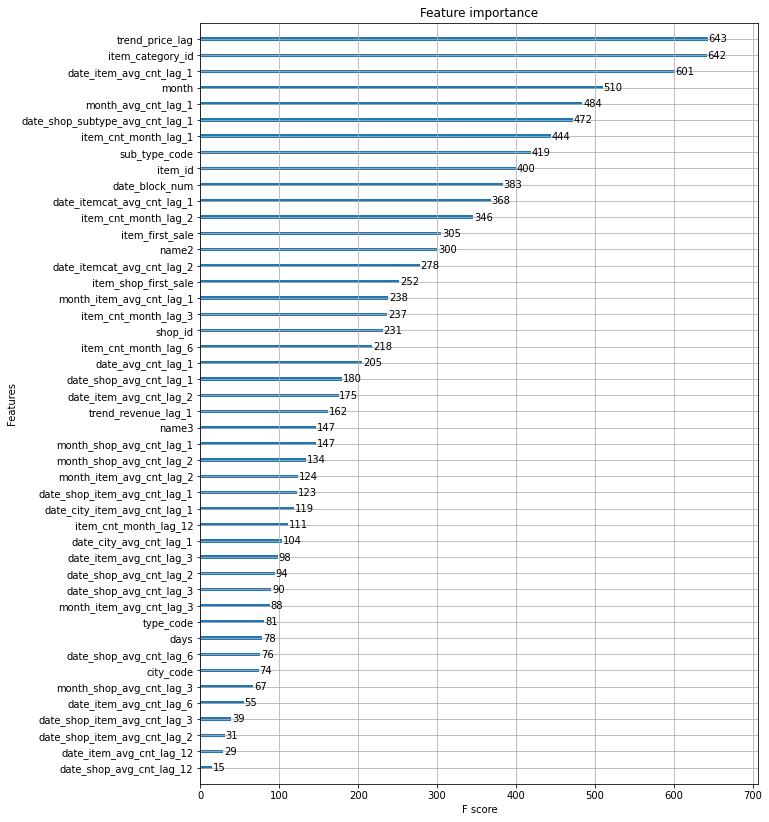

In [97]:
def plot_features(booster, figsize):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10, 14))